In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

0


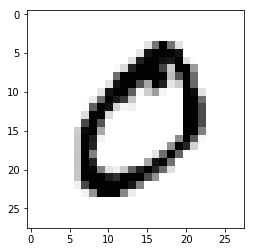

In [3]:
%matplotlib inline
image_index = 1 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.pyplot.imshow(x_train[image_index], cmap='Greys')

In [17]:
#there are 60000 examples and each is 28 by 28 pixels
# Intensity is from 0 - 255
print(x_train.shape)
# We're going to play around with different number of layers for the MINIST Dataset
# reshape the different layers
x_train_flatten = x_train.reshape(x_train.shape[0], -1).T
# x_train has been flattened 
print(x_train_flatten.shape)


(60000, 28, 28)
(784, 60000)


In [18]:
# Init function for L layer NN, input array of dimensions
def initialize_parameters_deep(layer_dims):    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [19]:
# One forward propagation for one layer
# cache inputs for backward propagation latter
# A, W should be two arrays that compliment each other
# b should be a nx1 array
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A,W,b)
    return Z , cache

In [20]:
def sigmoid(Z):
    A = 1/(1+np.exp-Z)
    cache = Z
    return A, cache
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

In [21]:
# cache is needed for us to use latter on for back propagation

def linear_activation_forward(A_prev, W, b, activation):
    if(activation == "sigmoid"):
        Z, linear_cache = linear_forward(A_prev ,W , b)
        A, activation_cache = sigmoid(Z)
    elif(activation == "relu"):
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
        
    return A, cache

In [23]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)],
                                          activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [24]:
# Cost Function 

def compute_cost(AL, Y):    

    m = Y.shape[1]
    cost = -np.sum((Y*np.log(AL)) + ((1-Y)* np.log(1-AL)))/m
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost


In [25]:
# BackProp you have the linear backwards, you have the linear activation backwards ++ you have L model backwards
# why do we

def linear_backwards(dZ,cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, keepdims = True)/m
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db
    

In [26]:
def relu_backward(dA, cache):    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [27]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [28]:
def L_Model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # init the gradient
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]

    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(
                                                                            sigmoid_backward(dAL, current_cache[1]),
                                                                                            current_cache[0])     
    for l in reversed(range(L-1)):
        current_cache = caches[1]
        dA_prev_temp, dW_temp, db_temp = linear_backward(sigmoid_backward(dAL, current_cache[1]),current_cache[0])
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [29]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    ### END CODE HERE ###
    return parameters

In [30]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=True):
    
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)

        
        cost = compute_cost(AL, Y)

    
        grads = L_model_backward(AL, Y, caches)

 
        parameters = update_parameters(parameters, grads, learning_rate)

                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters